In [1]:
import pandas as pd
import numpy as np
import os
import json
import glob
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from scipy.spatial import Delaunay
from utils import *

In [ ]:
# Load the JSON file
with open('./full_tracks_2.json', 'r') as f:
    df_tracks = json.load(f)

# Prepare rows for the DataFrame
rows = []
for entry in df_tracks:
    id_ = entry['id']
    team = entry['team']
    detections = entry['detections']
    for frame, values in detections.items():
        # Only process if values are in the expected format
        if len(values) >= 2:
            x = values[-2]
            y = values[-1]
            row = {
                'id': id_,
                'team': team,
                'frame': int(frame),
                'x': x,
                'y': y
            }
            rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)



In [4]:
df = df[df['team'] == 0]
df

,id,team,frame,x,y
0,1,0,681,0.361916,0.509247
1,1,0,682,0.365570,0.525081
2,1,0,683,0.366783,0.525507
3,1,0,684,0.367689,0.525821
4,1,0,685,0.368594,0.526133
...,...,...,...,...,...
2376791,257,0,134946,0.758526,0.510326
2376792,257,0,134976,0.793479,0.573286
2376793,257,0,134977,0.793349,0.574885
2376794,257,0,134984,0.972105,0.288295


In [5]:
def create_role_pdfs_of_tracks(df):

    players_role, initial_means = initialize_roles_with_kmeans_all(df, 10)

    players_role, role_pdfs = update_roles_all(players_role, initial_means, separation_bias=20.0)
    
    return players_role, role_pdfs

In [6]:
import pandas as pd

# Sort by frame to preserve temporal order
df_new = df.sort_values(by='frame')

# Find the first frame where each player ID appears
first_frames = df_new.groupby('id')['frame'].min().reset_index()

# Sort IDs by first appearance
sorted_ids = first_frames.sort_values(by='frame')['id'].tolist()

# Split IDs into chunks of 10
chunks = [sorted_ids[i:i + 10] for i in range(0, len(sorted_ids), 10)]


# Create blocks based on each ID chunk
blocks = []
for id_chunk in chunks:
    block_df = df[df['id'].isin(id_chunk)].copy()
    blocks.append(block_df.reset_index(drop=True))


In [7]:
blocks[0]

,id,team,frame,x,y
0,1,0,681,0.361916,0.509247
1,1,0,682,0.365570,0.525081
2,1,0,683,0.366783,0.525507
3,1,0,684,0.367689,0.525821
4,1,0,685,0.368594,0.526133
...,...,...,...,...,...
20446,10,0,2930,0.542890,0.999434
20447,10,0,2931,0.543566,1.000474
20448,10,0,2932,0.543161,1.001419
20449,10,0,2933,0.543936,1.001925


In [8]:
blocks[1][blocks[1]['id'] == 26].head(1)

,id,team,frame,x,y
36105,26,0,2935,0.449312,0.930063


In [9]:
remapped_blocks = []

for block in blocks:
    block = block.copy()

    # Get the 10 unique IDs in order of appearance in this block
    unique_ids = block['id'].drop_duplicates().tolist()
    
    # Map them to new unified IDs: 0–9
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
    
    # Apply the mapping
    block['id'] = block['id'].map(id_map)
    
    remapped_blocks.append(block)

# Merge all remapped blocks into one final dataframe
final_df = pd.concat(remapped_blocks, ignore_index=True)

# Check results
print("Final unique player IDs:", sorted(final_df['id'].unique()))


Final unique player IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
aligned_df = final_df.sort_values(by=['id', 'frame']).reset_index(drop=True)
aligned_df

,id,team,frame,x,y
0,0,0,681,0.361916,0.509247
1,0,0,682,0.365570,0.525081
2,0,0,683,0.366783,0.525507
3,0,0,684,0.367689,0.525821
4,0,0,685,0.368594,0.526133
...,...,...,...,...,...
1206716,9,0,134946,0.758526,0.510326
1206717,9,0,134976,0.793479,0.573286
1206718,9,0,134977,0.793349,0.574885
1206719,9,0,134984,0.972105,0.288295


In [11]:
aligned_df.iloc[15931:].head(10)

,id,team,frame,x,y
15931,0,0,17777,0.415114,0.677674
15932,0,0,17778,0.415242,0.678696
15933,0,0,17779,0.415452,0.678711
15934,0,0,17780,0.415324,0.677690
15935,0,0,17781,0.415534,0.677705
15936,0,0,17782,0.415745,0.677720
15937,0,0,17783,0.416082,0.678756
15938,0,0,17784,0.416082,0.678756
15939,0,0,17785,0.416417,0.679787
15940,0,0,17786,0.416627,0.679801


In [12]:
first_half_time_block = aligned_df[aligned_df['frame'] <= 67500]
first_half_time_block

,id,team,frame,x,y
0,0,0,681,0.361916,0.509247
1,0,0,682,0.365570,0.525081
2,0,0,683,0.366783,0.525507
3,0,0,684,0.367689,0.525821
4,0,0,685,0.368594,0.526133
...,...,...,...,...,...
1146211,9,0,67496,0.384747,0.990329
1146212,9,0,67497,0.384838,0.990280
1146213,9,0,67498,0.384838,0.990280
1146214,9,0,67499,0.384747,0.990329


In [13]:

# Assume df is your dataframe, and 'id' is the ID column name
unique_ids = first_half_time_block['id'].unique()
num_splits = 5

# Create list to hold the resulting dataframes
split_dfs = [pd.DataFrame() for _ in range(num_splits)]

# Split each ID's rows into 5 parts and distribute them
for uid in unique_ids:
    group = first_half_time_block[first_half_time_block['id'] == uid]
    split = np.array_split(group, num_splits)  # Automatically handles uneven splits
    for i in range(num_splits):
        split_dfs[i] = pd.concat([split_dfs[i], split[i]], ignore_index=True)

# Now split_dfs[0] through split_1_half_dfs[4] contain chunks of each ID

split_dfs[4]

,id,team,frame,x,y
0,0,0,54199,0.504457,0.937559
1,0,0,54200,0.504106,0.937069
2,0,0,54201,0.503613,0.937324
3,0,0,54202,0.503287,0.937234
4,0,0,54203,0.503005,0.937156
...,...,...,...,...,...
121523,9,0,67496,0.384747,0.990329
121524,9,0,67497,0.384838,0.990280
121525,9,0,67498,0.384838,0.990280
121526,9,0,67499,0.384747,0.990329


In [14]:
for i, split_df in enumerate(split_dfs):
   
    split_df['xworld'] = split_df['x'] * 105
    split_df['yworld'] = split_df['y'] * 68
    split_df[['xworld_norm', 'yworld_norm']] = split_df.groupby('frame')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean())
    print(split_df.head())

   id  team  frame         x         y     xworld     yworld  xworld_norm  \
0   0     0    681  0.361916  0.509247  38.001192  34.628792     5.115918   
1   0     0    682  0.365570  0.525081  38.384871  35.705517     5.421162   
2   0     0    683  0.366783  0.525507  38.512173  35.734451     5.255969   
3   0     0    684  0.367689  0.525821  38.607383  35.755857     5.053252   
4   0     0    685  0.368594  0.526133  38.702368  35.777014     5.170107   

   yworld_norm  
0    18.204964  
1    19.179397  
2    18.638418  
3    17.865526  
4    17.958497  
   id  team  frame         x         y     xworld     yworld  xworld_norm  \
0   0     0  14201  0.263049  0.872149  27.620182  59.306138    -9.871576   
1   0     0  14202  0.264474  0.873190  27.769802  59.376929    -9.722794   
2   0     0  14203  0.265159  0.873137  27.841735  59.373323    -9.632223   
3   0     0  14204  0.266561  0.874165  27.988947  59.443202    -9.473276   
4   0     0  14205  0.268216  0.875158  28.162629 

In [15]:
every_4th_split_dfs = [df.iloc[::8].reset_index(drop=True) for df in split_dfs]
for i, df in enumerate(every_4th_split_dfs):
    print(f"Split {i} shape: {df.shape}")
   

Split 0 shape: (15192, 9)
Split 1 shape: (15192, 9)
Split 2 shape: (15192, 9)
Split 3 shape: (15192, 9)
Split 4 shape: (15191, 9)


In [16]:
every_4th_split_dfs[0].head(10)

,id,team,frame,x,y,xworld,yworld,xworld_norm,yworld_norm
0,0,0,681,0.361916,0.509247,38.001192,34.628792,5.115918,18.204964
1,0,0,689,0.372236,0.536040,39.084769,36.450696,5.297604,18.000696
2,0,0,697,0.375461,0.540461,39.423406,36.751366,5.381386,18.075477
3,0,0,705,0.378791,0.567311,39.773107,38.577151,5.293556,18.602176
4,0,0,713,0.381010,0.595870,40.006049,40.519128,5.569243,20.525735
5,0,0,721,0.372124,0.609970,39.073041,41.477959,3.713458,20.211895
6,0,0,729,0.353352,0.596227,37.101975,40.543430,3.402233,21.193573
7,0,0,737,0.357511,0.665058,37.538619,45.223917,3.273929,23.946320
8,0,0,745,0.345916,0.689235,36.321143,46.868006,2.198795,23.695689
9,0,0,753,0.331993,0.706200,34.859297,48.021607,0.982217,23.715339


In [17]:
# Load the fitted label encoder (recommended way)
label_encoder = joblib.load('./label_encoder.pkl')
adjacency_matrices = []
players_roles_list = []
role_pdfs_list = []

for i, df in enumerate(every_4th_split_dfs):
    players_role, role_pdfs = create_role_pdfs_of_tracks(df)
    
    # Mirror the means in both x and y axes
    for pdf in role_pdfs.values():
        pdf.mean[0] = -pdf.mean[0]
        pdf.mean[1] = -pdf.mean[1]
    
    players_roles_list.append(players_role)
    role_pdfs_list.append(role_pdfs)
    role_means = np.array([pdf.mean for pdf in role_pdfs.values()])

    # Check if there are enough points for Delaunay triangulation
    if len(role_means) >= 3:
        # Perform Delaunay triangulation
        tri = Delaunay(role_means)

        # Initialize adjacency matrix
        adj_matrix = np.zeros((len(role_means), len(role_means)))

        # Populate adjacency matrix based on Delaunay simplices
        for simplex in tri.simplices:
            for i in range(len(simplex)):
                for j in range(i + 1, len(simplex)):
                    distance = np.linalg.norm(role_means[simplex[i]] - role_means[simplex[j]])
                    adj_matrix[simplex[i], simplex[j]] = distance
                    adj_matrix[simplex[j], simplex[i]] = distance
        adjacency_matrices.append(adj_matrix)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14


In [18]:
import joblib
for i, matr in enumerate(adjacency_matrices):
    # Step 1: Extract features from the new adjacency matrix
    new_features = extract_features(matr)

    # Step 2: Reshape to 2D array for prediction
    new_features = new_features.reshape(1, -1)

    # Step 3: Predict using the KNN model
    knn_model = joblib.load('./KNN_best_model.pkl')
    predicted_label_encoded = knn_model.predict(new_features)[0]

    # Step 4: Load the fitted label encoder
    label_encoder = joblib.load('./label_encoder.pkl')

    # Step 5: Decode the predicted label
    predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

    print("Predicted formation (decoded):", predicted_label)


Predicted formation (decoded): 4231
Predicted formation (decoded): 4231
Predicted formation (decoded): 4231
Predicted formation (decoded): 352
Predicted formation (decoded): 4231


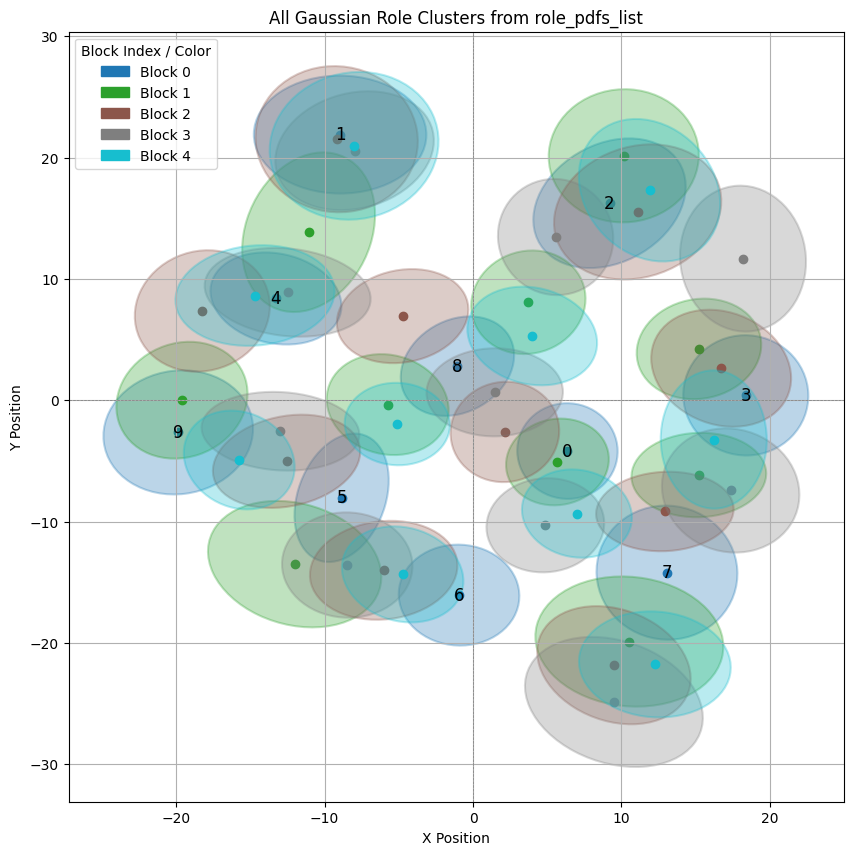

In [19]:
from matplotlib.patches import Ellipse, Patch
import matplotlib.pyplot as plt
def plot_gaussian_ellipse(mean, cov, ax, label=None, alpha=0.5, color=None):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * np.sqrt(eigvals)
    ellipse = Ellipse(mean, width, height, angle=angle, alpha=alpha, lw=1.5, edgecolor=color, facecolor=color)
    ax.add_patch(ellipse)
    ax.scatter(mean[0], mean[1], color=color)
    if label is not None:
        ax.text(mean[0], mean[1], str(label), color='black', fontsize=12, ha='center', va='center')
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(role_pdfs_list)))
legend_handles = []
for idx, role_pdfs in enumerate(role_pdfs_list):
    color = colors[idx % len(colors)]
    legend_handles.append(Patch(color=color, label=f'Block {idx}'))
    for role, pdf in role_pdfs.items():
        mean = pdf.mean
        cov = pdf.cov
        plot_gaussian_ellipse(mean, cov, ax, label=f"{role}" if idx == 0 else None, alpha=0.3, color=color)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("All Gaussian Role Clusters from role_pdfs_list")
plt.grid(True)
ax.legend(handles=legend_handles, title="Block Index / Color")
plt.show()




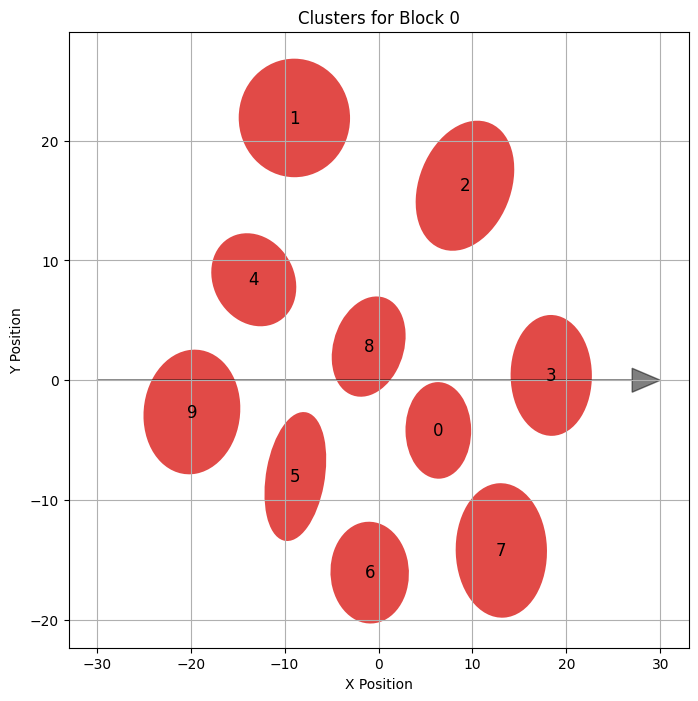

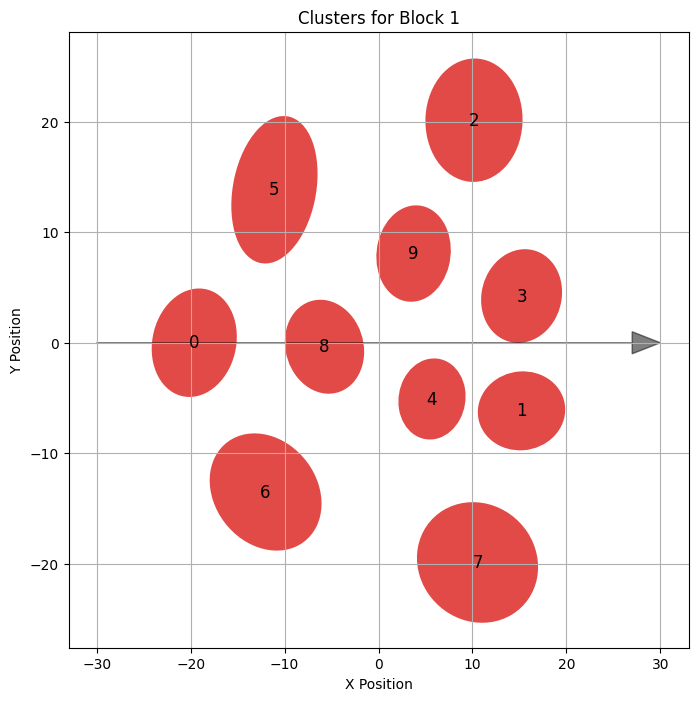

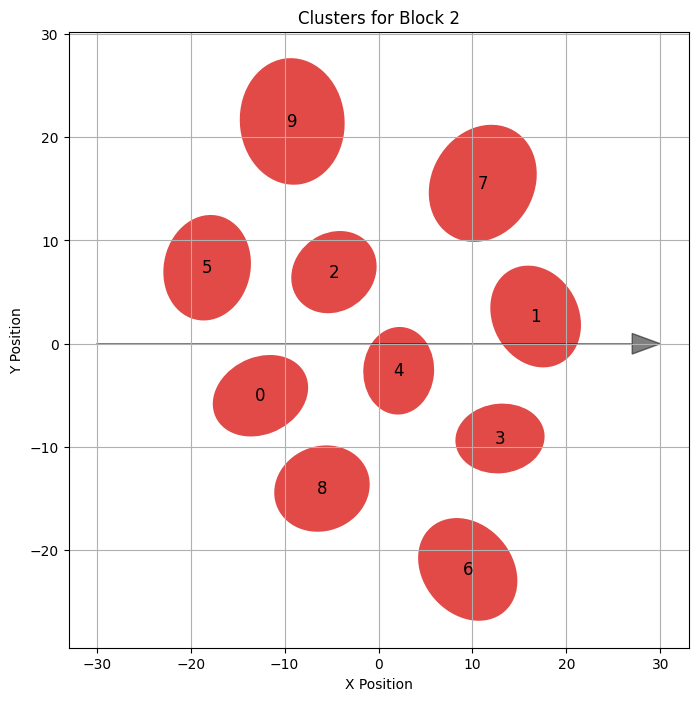

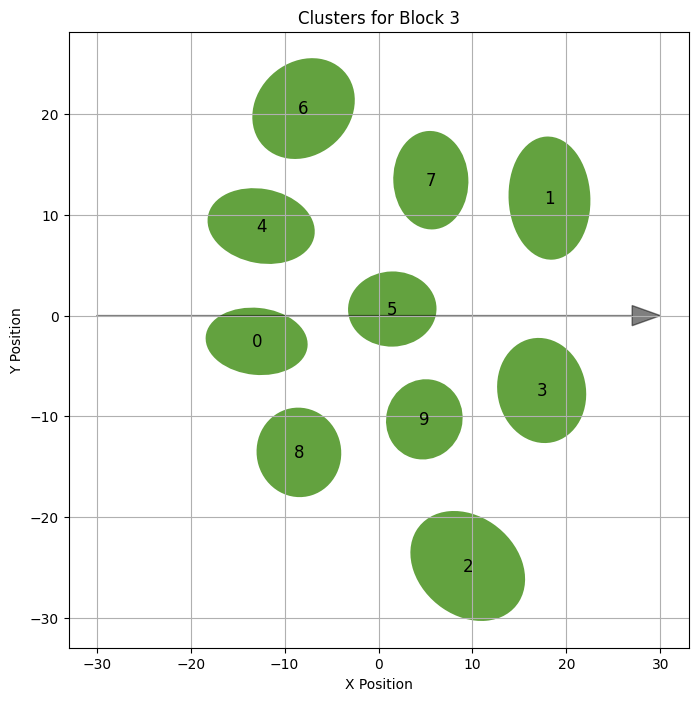

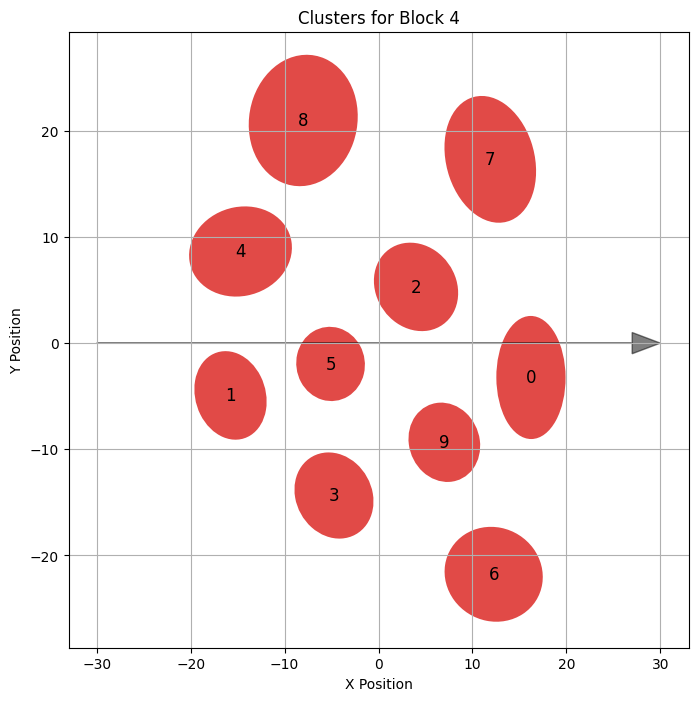

In [22]:
custom_colors = [
    (225/255, 74/255, 71/255),  
     (225/255, 74/255, 71/255),
    (225/255, 74/255, 71/255),   
      (99/255, 162/255, 63/255),    
      (225/255, 74/255, 71/255),  
    colors[4]                    # Fifth: keep as before or set as needed
]

for idx, role_pdfs in enumerate(role_pdfs_list):
    fig, ax = plt.subplots(figsize=(8, 8))
    color = custom_colors[idx]
    for role, pdf in role_pdfs.items():
        mean = pdf.mean
        cov = pdf.cov
        plot_gaussian_ellipse(mean, cov, ax, label=f"{role}", alpha=1, color=color)
    # Draw left-to-right arrow
    ax.arrow(-30, 0, 60, 0, head_width=2, head_length=3, fc='black', ec='black', alpha=0.5, length_includes_head=True)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_title(f"Clusters for Block {idx}")
    plt.grid(True)
    plt.show()
